In [1]:
import numpy as np
from numpy.linalg import norm
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from keras.models import load_model
from PIL import Image

import tensorflow as tf
from keras import Sequential
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [2]:
model_path = '/kaggle/input/facenet/keras-facenet/model/facenet_keras.h5'
base_model = load_model(model_path)

In [6]:
train_dir = '/kaggle/input/facesrec/New folder'

In [7]:
train_datagen = ImageDataGenerator(rescale=1.0/255, 
                                   horizontal_flip=True, 
                                   vertical_flip = True,
                                   rotation_range = 90,
                                   shear_range = 0.4,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range=0.2,
                                   validation_split=0.2,
                                   fill_mode = 'nearest')
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(160,160),class_mode='categorical',
                                                    batch_size=4,
                                                    subset='training')

val_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(160,160),class_mode='categorical',
                                                subset='validation',
                                                batch_size=4)

Found 123 images belonging to 11 classes.
Found 24 images belonging to 11 classes.


In [9]:
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation = 'relu'),
    Dense(11, activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v1 (Functio (None, 128)               22808144  
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 11)                2827      
Total params: 23,008,347
Trainable params: 200,203
Non-trainable params: 22,808,144
_________________________________________________________________


In [10]:
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                            patience=10,
                                            mode='min',
                                            restore_best_weights=True)

In [11]:
model.compile(optimizer="adam",loss="categorical_crossentropy", metrics ="categorical_accuracy")

In [12]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator)//4,
                    epochs=100,
                    validation_data=val_generator,
                    verbose=1,
                    callbacks=[early_stopping_callback])

Epoch 1/100
7/7 [==============================] - 24s 2s/step - loss: 2.4754 - categorical_accuracy: 0.0714 - val_loss: 2.5249 - val_categorical_accuracy: 0.0833
Epoch 2/100
7/7 [==============================] - 10s 2s/step - loss: 2.4698 - categorical_accuracy: 0.0741 - val_loss: 2.4637 - val_categorical_accuracy: 0.0833
Epoch 3/100
7/7 [==============================] - 10s 1s/step - loss: 2.5890 - categorical_accuracy: 0.0357 - val_loss: 2.3934 - val_categorical_accuracy: 0.2083
Epoch 4/100
7/7 [==============================] - 11s 2s/step - loss: 2.3785 - categorical_accuracy: 0.1429 - val_loss: 2.3815 - val_categorical_accuracy: 0.1667
Epoch 5/100
7/7 [==============================] - 11s 2s/step - loss: 2.3350 - categorical_accuracy: 0.2143 - val_loss: 2.3900 - val_categorical_accuracy: 0.1250
Epoch 6/100
7/7 [==============================] - 11s 2s/step - loss: 2.2156 - categorical_accuracy: 0.2500 - val_loss: 2.4610 - val_categorical_accuracy: 0.0833
Epoch 7/100
7/7 [=====

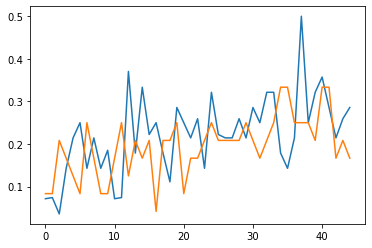

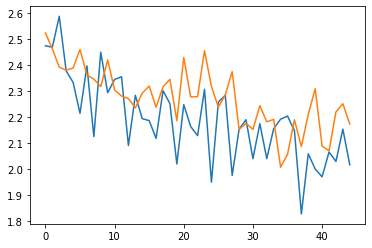

In [14]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs,acc)
plt.plot(epochs,val_acc)

plt.figure()

plt.plot(epochs,loss)
plt.plot(epochs,val_loss)

In [15]:
model.save('facerec.h5')

In [16]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'facerec.h5')

/kaggle/working/facerec.h5